In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyvibdmc.analysis import *
from pyvibdmc.simulation_utilities import *
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense
from pyvibdmc import potential_manager as pm
import sys,os

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
pot_dir = '/home/fenris/McCoy_Group/dvr/sample_potentials/FortPots/Partridge_Schwenke_H2O/'
py_file = 'h2o_potential.py'
pot_func = 'water_pot'

water_pot_ps = pm.Potential(potential_function=pot_func,
                      python_file=py_file,
                      potential_directory=pot_dir,
                      num_cores=8)


Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-1:
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-8:
Traceback (most recent call last):
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fenris/anaconda3/envs/rosetta/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/fenris/anaconda3/envs/rosetta/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fenris/anaconda3/envs/rosetta/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/fenris/anaconda3/envs/rosetta/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "

In [4]:
def load_training(training_name):
    """If using deb_training_every argument, read the files with this."""
    with h5py.File(training_name, 'r') as f:
        cds = f['coords'][:]
        vs = f['pots'][:]
    return cds, Constants.convert(vs, "wavenumbers", to_AU=False)


def get_ml_data(ts):
    tot_x = []
    tot_v = []
    for time in ts:
        cds, vs = load_training(f"training_water_dt1_1_training_{time}ts.hdf5")
        print(cds.shape)
        tot_x.append(cds.squeeze())
        tot_v.append(vs)
    tot_x = np.concatenate(tot_x)
    tot_v = np.concatenate(tot_v)
    return tot_x, tot_v


def plot_training_data(cds, pots):
    plt.scatter(cds, pots)

def clean_training_data(train_x, train_y,diffmat):
    threshold = 0.001
    # death_matels = np.zeros(diffmat.shape)
    final_x = np.zeros(train_x.shape)
    for row_num,row in enumerate(diffmat):
        #calculate threshold
        diffz = row[row_num+1:]
        death_mark = np.abs(diffz) < threshold
        final_x += np.concatenate((np.zeros(row_num+1),death_mark))
        # death_matels[row_num, np.where(death_mark)[0]] = 1
    np.delete(train_x, final_x)
    np.delete(train_y, final_x)
    print('hi')
    train_x

def difference_matrix(train_x):
    x = np.reshape(train_x, (len(train_x), 1))
    return x - x.transpose()

def internals_h2O(cds):
    analyzer = AnalyzeWfn(cds)
    bl1 = analyzer.bond_length(0,2)
    bl2 = analyzer.bond_length(1,2)
    theta = analyzer.bond_angle(0,2,1)
    return np.array((bl1,bl2,theta)).T

tss = [100, 200, 300, 400, 500, 600, 700, 900]
tss = [100, 200]
train_x, train_y = get_ml_data(tss)
train_x = internals_h2O(train_x)

val_set = [800]
val_x, val_y = get_ml_data(val_set)
val_x = internals_h2O(val_x)

(10012, 3, 3)
(9989, 3, 3)
(10005, 3, 3)


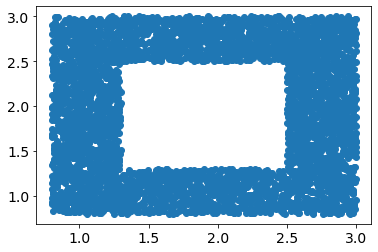

In [32]:
r_min = 1.3
r_max = 2.5
theta_min = 1.1
theta_max = 2.6
d = 0.5

train_h_x = []

while len(train_h_x) < 5000:
    r_1 = np.random.random(1)*(r_max-r_min+2*d)+r_min-d
    r_2 = np.random.random(1)*(r_max-r_min+2*d)+r_min-d
    theta = np.random.random(1)*(theta_max-theta_min+2*d)+theta_min-d
    if not ((r_min < r_1[0] < r_max) and (r_min < r_2[0] < r_max) and (theta_min < r_1[0] < theta_max)):
        train_h_x.append((r_1[0], r_2[0], theta[0]))
    
train_h_x = np.array(train_h_x)
plt.scatter(train_h_x[:,0], train_h_x[:,1])

In [7]:
def inner_to_cart(inner):
    cd = np.zeros((inner.shape[0],3,3))
    cd[:,0,0] = inner[:,0]
    cd[:,1,0] = inner[:,1] * np.cos(inner[:,2])
    cd[:,1,1] = inner[:,1] * np.sin(inner[:,2])
    return cd

train_h_x_cart = inner_to_cart(train_h_x)
train_h_y = water_pot_ps.getpot(train_h_x_cart)
train_h_y = Constants.convert(train_h_y, "wavenumbers", to_AU=False)

In [10]:
from random import shuffle

train_data = [(x, y) for x,y in zip(train_x, train_y)] + [(x, y) for x,y in zip(train_h_x, train_h_y)]
shuffle(train_data)

train_x_ready = np.array([x for x,y in train_data])
train_y_ready = np.array([y for x,y in train_data])

In [11]:
X_MIN = 0
X_MAX = 3

def normalize_x(x):
    return 2*(x-X_MIN)/(X_MAX-X_MIN)-1

train_x_ready = normalize_x(train_x_ready)
val_x = normalize_x(val_x)

train_y_ready = np.log10(train_y_ready)

In [12]:
model = tf.keras.Sequential(
[
    tf.keras.Input(shape=(3,)),
    Dense(64, activation=tf.nn.swish),
    Dense(64, activation=tf.nn.swish),
    Dense(64, activation=tf.nn.swish),
    Dense(1, activation='linear')
]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________


In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

model.compile(optimizer=optimizer,
                 loss='mse',
                 metrics=[])

In [44]:
history = model.fit(train_x_ready, train_y_ready, validation_split=0.1, batch_size=32, epochs=500)

Epoch 1/500
704/704 [==============================] - 1s 2ms/step - loss: 3.1489e-06 - val_loss: 1.1389e-05
Epoch 2/500
704/704 [==============================] - 1s 2ms/step - loss: 3.5043e-06 - val_loss: 7.2416e-06
Epoch 3/500
704/704 [==============================] - 1s 2ms/step - loss: 3.3018e-06 - val_loss: 8.4793e-06
Epoch 4/500
704/704 [==============================] - 1s 2ms/step - loss: 3.3684e-06 - val_loss: 6.2825e-06
Epoch 5/500
704/704 [==============================] - 1s 2ms/step - loss: 3.3486e-06 - val_loss: 9.1456e-06
Epoch 6/500
704/704 [==============================] - 1s 2ms/step - loss: 3.4152e-06 - val_loss: 7.8302e-06
Epoch 7/500
704/704 [==============================] - 1s 2ms/step - loss: 3.6374e-06 - val_loss: 8.1006e-06
Epoch 8/500
704/704 [==============================] - 1s 2ms/step - loss: 3.2576e-06 - val_loss: 5.7252e-06
Epoch 9/500
704/704 [==============================] - 1s 2ms/step - loss: 3.2105e-06 - val_loss: 9.6641e-06
Epoch 10/500
704/70

704/704 [==============================] - 1s 2ms/step - loss: 3.3041e-06 - val_loss: 9.4352e-06
Epoch 76/500
704/704 [==============================] - 1s 2ms/step - loss: 3.3386e-06 - val_loss: 1.0878e-05
Epoch 77/500
704/704 [==============================] - 1s 2ms/step - loss: 3.3776e-06 - val_loss: 1.0408e-05
Epoch 78/500
704/704 [==============================] - 1s 2ms/step - loss: 3.5926e-06 - val_loss: 6.9004e-06
Epoch 79/500
704/704 [==============================] - 1s 2ms/step - loss: 3.3349e-06 - val_loss: 6.7882e-06
Epoch 80/500
704/704 [==============================] - 1s 2ms/step - loss: 3.0536e-06 - val_loss: 1.1975e-05
Epoch 81/500
704/704 [==============================] - 1s 2ms/step - loss: 3.5931e-06 - val_loss: 7.8451e-06
Epoch 82/500
704/704 [==============================] - 1s 2ms/step - loss: 3.1442e-06 - val_loss: 6.4647e-06
Epoch 83/500
704/704 [==============================] - 1s 2ms/step - loss: 3.2415e-06 - val_loss: 7.9815e-06
Epoch 84/500
704/704 [=

704/704 [==============================] - 1s 2ms/step - loss: 3.1512e-06 - val_loss: 8.6368e-06
Epoch 150/500
704/704 [==============================] - 1s 2ms/step - loss: 3.3647e-06 - val_loss: 7.7904e-06
Epoch 151/500
704/704 [==============================] - 1s 2ms/step - loss: 3.3155e-06 - val_loss: 6.4456e-06
Epoch 152/500
704/704 [==============================] - 1s 2ms/step - loss: 3.3225e-06 - val_loss: 6.7296e-06
Epoch 153/500
704/704 [==============================] - 1s 2ms/step - loss: 3.2574e-06 - val_loss: 7.0352e-06
Epoch 154/500
704/704 [==============================] - 1s 2ms/step - loss: 3.0294e-06 - val_loss: 6.0711e-06
Epoch 155/500
704/704 [==============================] - 1s 2ms/step - loss: 3.1496e-06 - val_loss: 1.0132e-05
Epoch 156/500
704/704 [==============================] - 1s 2ms/step - loss: 2.9590e-06 - val_loss: 8.0978e-06
Epoch 157/500
704/704 [==============================] - 1s 2ms/step - loss: 3.5939e-06 - val_loss: 7.4807e-06
Epoch 158/500
7

KeyboardInterrupt: 

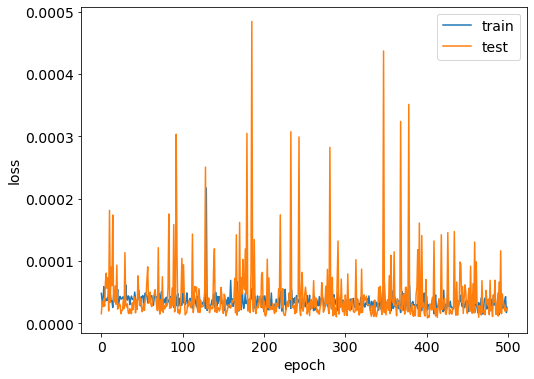

In [22]:
def plot_result(val_x, val_y, history, model):
    fig = plt.figure(figsize=(8,6))
    ax_loss = fig.add_subplot(111)
#    ax_data = fig.add_subplot(212)
    
    ax_loss.plot(history.history['loss'])
    ax_loss.plot(history.history['val_loss'])
    ax_loss.set_ylabel('loss')
    ax_loss.set_xlabel('epoch')
    ax_loss.legend(['train', 'test'], loc='upper right')
    
#     ax_data.scatter(val_x,val_y)
#     ax_data.scatter(val_x, model.predict(val_x), marker='|')
#     ax_data.legend(['Analytic', 'Predicted'], loc='upper right')
    
    plt.show()
    
plot_result(val_x, val_y, history, model)

In [45]:
print("       Label        Predicted")
val_data = np.concatenate((np.expand_dims(val_y, axis=1), 10**model.predict(val_x)),axis=1)
print(val_data[:10])

       Label        Predicted
[[ 5049.68186109  5060.71289062]
 [  717.14191168   719.98571777]
 [ 5966.28704558  5989.05810547]
 [  598.95307243   600.45904541]
 [15837.89958316 15805.41113281]
 [  287.54386184   287.34841919]
 [11034.94825861 10990.04394531]
 [ 4276.68022732  4260.59130859]
 [ 3409.25650976  3416.44238281]
 [ 3664.63140549  3685.59277344]]


(-0.001, 0.02)

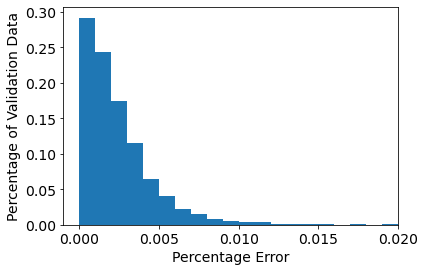

In [46]:
weights = np.ones_like(val_data[:,0]) / len(val_data[:,0])
plt.hist(np.abs(val_data[:,0]-val_data[:,1])/val_data[:,0], bins=np.arange(0,1,0.001), weights=weights)
plt.xlabel('Percentage Error')
plt.ylabel('Percentage of Validation Data')
plt.xlim((-0.001,0.02))

In [47]:
model.save_weights('h2o_3x64_1.h5')

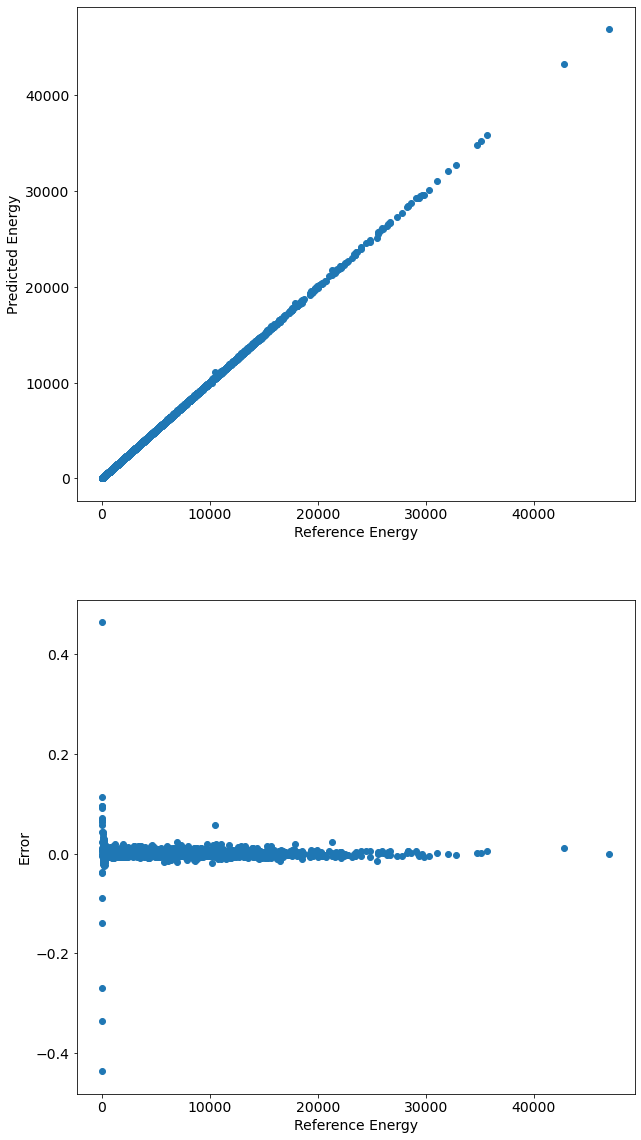

In [48]:
def plot_dis_vec(x1, x2):
    fig = plt.figure(figsize=(10,20))

    loss = fig.add_subplot(2,1,1)
    loss.scatter(x1, x2)
    loss.set_xlabel('Reference Energy')
    loss.set_ylabel('Predicted Energy')
    
    percent_loss = fig.add_subplot(2,1,2)
    percent_loss.scatter(x1, (x2-x1)/x1)
    percent_loss.set_xlabel('Reference Energy')
    percent_loss.set_ylabel('Error')
    
    plt.show()
    
plot_dis_vec(val_data[:,0], val_data[:,1])